# Example of running ML inference with an ONNX model in openEO
This notebook shows how to run inference with a trained model in the ONNX format. 
In this example, we use a Convolutional Neural Network (CNN) that is applied on a window of 256x256 pixels of a Sentinel-2 band. After training, the model has been converted to the ONNX format. 
More information on how to do this for your own model can be found here: https://github.com/onnx/tutorials#converting-to-onnx-format

We first set up the connection with an openEO backend and load some data as usual.

In [24]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [25]:
spatial_extent = {
    "west": 4.217639,
    "south": 51.162882,
    "east": 4.477856,
    "north": 51.260197
}
temporal_extent = ["2021-01-01", "2022-04-01"]
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands=["B04"],
    max_cloud_cover=20,
)

After setting up the connection with a back-end, we define where both the dependencies and the model are stored.

### Dependencies
In order to remain lightweight, an openEO backend does not have the necessary dependencies to run the model. Therefore, we need to pass the extra dependencies to the backend. If you are using an ONNX model that can be run with ONNX Runtime version 1.16.3, you can use the dependencies url provided in the code below. If you are using a different version of ONNX Runtime, you need to provide the dependencies yourself.

More information on onnx version compatibility can be found here: https://github.com/onnx/tutorials#converting-to-onnx-format

More information on how to make a dependency archive for openeo can be found here: https://documentation.dataspace.copernicus.eu/APIs/openEO/job_config.html#custom-udf-dependencies

### Model
The model needs to be stored in a location that is accessible by the backend. In this example, we store the model in the same location as the dependencies. You could however also store the model in a public github repository and provide the url to the backend.

In [26]:
# This will be required to import onnxruntime in the UDF.
dependencies_url = "https://artifactory.vgt.vito.be:443/auxdata-public/openeo/onnx_dependencies_1.16.3.zip"
# You can upload your own model to a public download link and paste the url here. An example of a public storage is github, or you can set up a public S3 bucket.
model_url = "https://artifactory.vgt.vito.be:443/auxdata-public/openeo/test_onnx_model.zip"

Next we load the udf that will run the model. Make sure to take a look at [the udf code](./onnx_udf.py) to understand how and why the loading of the model is cached to reduce your processing costs, how you can work with the named dimensions of an Xarray and how to run a model on each separate timestep.

We use the process `apply_neighborhood` to apply the udf. The model accepts a window of 256x256 pixels. In order to get a smooth result, we apply the model on overlapping windows. The values included in the overlap will not be modified.\
In this case an overlap of 16 pixels is used on both sides, so the remaining size of 224x224 pixels will be modified each step.

Other models might perform pixel-wise predictions (e.g. random forests) in which case you can simply use the `apply` process. The openEO backend will then automatically handle the chunking and stitching of the results.\
In case you only want to keep your prediction, instead of using `apply` you can use the `reduce dimension` process to only keep the prediction and not the input bands.

In [32]:
# Load the UDF from a file.
udf = openeo.UDF.from_file(
    "onnx_udf.py",
    context=None, # you can pass extra arguments to the UDF here
)

# Apply the UDF to the data cube.
onnx_result = s2_cube.apply_neighborhood(
    udf,
    size=[
        {"dimension": "x", "value": 224, "unit": "px"},
        {"dimension": "y", "value": 224, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 16, "unit": "px"},
        {"dimension": "y", "value": 16, "unit": "px"}
    ],
)

mean_result = onnx_result.mean_time()

Finally, we add the dependencies to the job-options and run the process on the back-end.

In [ ]:
# We pass the model and dependencies as zip files to the UDF through the job options.
# The zip files provided in this list will be extracted in the UDF environment in a folder indicated by the name after the # symbol.
job_options = {
    "udf-dependency-archives": [
        f"{dependencies_url}#onnx_deps",
        f"{model_url}#onnx_models",
    ],
}
mean_result.execute_batch("results/output.tiff", job_options=job_options)

0:00:00 Job 'j-250610201416427bae0fd82fc65e6854': send 'start'
0:00:14 Job 'j-250610201416427bae0fd82fc65e6854': created (progress 0%)
0:00:20 Job 'j-250610201416427bae0fd82fc65e6854': created (progress 0%)
0:00:26 Job 'j-250610201416427bae0fd82fc65e6854': created (progress 0%)
0:00:34 Job 'j-250610201416427bae0fd82fc65e6854': created (progress 0%)
0:00:44 Job 'j-250610201416427bae0fd82fc65e6854': created (progress 0%)
0:00:56 Job 'j-250610201416427bae0fd82fc65e6854': running (progress N/A)
0:01:12 Job 'j-250610201416427bae0fd82fc65e6854': running (progress N/A)
0:01:31 Job 'j-250610201416427bae0fd82fc65e6854': running (progress N/A)
0:01:55 Job 'j-250610201416427bae0fd82fc65e6854': running (progress N/A)
0:02:25 Job 'j-250610201416427bae0fd82fc65e6854': running (progress N/A)
0:03:02 Job 'j-250610201416427bae0fd82fc65e6854': running (progress N/A)
0:03:49 Job 'j-250610201416427bae0fd82fc65e6854': running (progress N/A)
0:04:48 Job 'j-250610201416427bae0fd82fc65e6854': running (progres

<BatchJob job_id='j-250610201416427bae0fd82fc65e6854'>

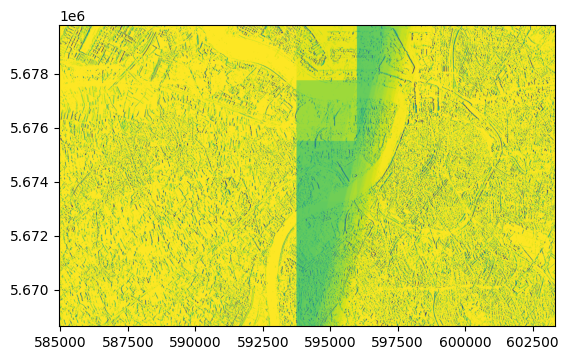

In [39]:
import rasterio
from rasterio.plot import show

with rasterio.open("results/output.tiff") as image:
    show(image)